# Customer segmentation (clustering)
## Hotel Customer Data
### This notebook was developed by:

- João Venichand - 20211644
- Gonçalo Custódio - 20211643
- Diogo Correia - 20211586
- Duarte Emanuel - 200564

### Data Description
Dataset related to customer behavior and preferences in a hotel context. Contains historical booking patterns, revenue data, and customer-specific preferences.

#### Customer Information:
- **ID**: Unique customer identifier (numeric)
- **Nationality**: Customer nationality (categorical: e.g., 'BRA', 'USA')
- **Age**: Customer age (numeric)
- **DaysSinceCreation**: Days since the customer account was created (numeric)
- **NameHash**: Anonymized hash of the customer’s name (text)
- **DocIDHash**: Anonymized hash of the customer’s ID document (text)
- **LodgingRevenue**: Total lodging revenue (numeric)
- **OtherRevenue**: Total revenue from non-lodging services (e.g., food, spa) (numeric)
- **MarketSegment**: Customer market segment (e.g., 'corporate', 'leisure') (categorical)

#### Booking Behaviour:
- **AverageLeadTime**: Average days between booking and arrival date (numeric)
- **BookingsCanceled**: Total canceled bookings by the customer (numeric)
- **BookingsNoShowed**: Total "no-show" bookings (numeric)
- **BookingsCheckedin**: Total bookings that resulted in stays (numeric)
- **PersonNights**: Total person-nights stayed (adults + children × nights) (numeric)
- **RoomNights**: Total room-nights stayed (rooms × nights) (numeric)
- **DistributionChannel**: Booking distribution channel (e.g., 'direct', 'agency') (categorical)

#### Customer Preferences (Binary: 0 = No, 1 = Yes)
- **SRHighFloor**: Requests rooms on higher floors
- **SRLowFloor**: Requests rooms on lower floors
- **SRMediumFloor**: Requests rooms on middle floors
- **SRAccessibleRoom**: Requests accessible rooms
- **SRBathtub**: Requests rooms with bathtubs
- **SRShower**: Requests rooms with showers
- **SRCrib**: Requests cribs
- **SRKingSizeBed**: Requests king-size beds
- **SRTwinBed**: Requests twin beds
- **SRNearElevator**: Requests rooms near elevators
- **SRAwayFromElevator**: Requests rooms away from elevators
- **SRNoAlcoholInMiniBar**: Requests mini-bars without alcohol
- **SRQuietRoom**: Requests quiet rooms

## Importing Libraries


__`Step 1`__ Import the required libraries.

In [1]:
import pandas as pd 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import seaborn as sns
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
import umap
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\jgven\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Understanding 


__`Step 2`__ Import the dataset, storing it in the data frame **data**.

In [2]:
data = pd.read_csv('Case1_HotelCustomerSegmentation.csv', sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111733 entries, 0 to 111732
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    111733 non-null  int64  
 1   Nationality           111733 non-null  object 
 2   Age                   107561 non-null  float64
 3   DaysSinceCreation     111733 non-null  int64  
 4   NameHash              111733 non-null  object 
 5   DocIDHash             110732 non-null  object 
 6   AverageLeadTime       111733 non-null  int64  
 7   LodgingRevenue        111733 non-null  float64
 8   OtherRevenue          111733 non-null  float64
 9   BookingsCanceled      111733 non-null  int64  
 10  BookingsNoShowed      111733 non-null  int64  
 11  BookingsCheckedIn     111733 non-null  int64  
 12  PersonsNights         111733 non-null  int64  
 13  RoomNights            111733 non-null  int64  
 14  DistributionChannel   111733 non-null  object 
 15  

# APAGAR AS HASHES

In [3]:
# Identify customers (DocIDHash) that appear more than once
duplicated_clients = data['DocIDHash'].value_counts()
duplicated_clients = duplicated_clients[duplicated_clients > 1].index  # Select only duplicated customers

# Remove all rows where DocIDHash is duplicated or missing
data = data[~data['DocIDHash'].isin(duplicated_clients) & data['DocIDHash'].notna()]

print(f"Final dataset size after removing duplicate and missing DocIDHash: {data.shape[0]} rows")


Final dataset size after removing duplicate and missing DocIDHash: 100395 rows


In [4]:
data.drop(columns=["NameHash", "DocIDHash", "MarketSegment"], inplace=True)

__`Step 3`__ Display the data.

In [5]:
data.head(5)

,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,52.0,440,59,292.0,82.3,1,0,2,...,0,0,0,0,0,0,0,0,0,0
2,3,DEU,32.0,1385,0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,FRA,61.0,1385,93,240.0,60.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,FRA,52.0,1385,0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,JPN,55.0,1385,58,230.0,24.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


__`Step 4`__ Turn the ID into the index of the data.

In [6]:
if data['ID'].duplicated().any():
    print("There are duplicate IDs in the dataset.")
else:
    data.set_index('ID', inplace=True)

__`Step 5`__ Summary statistics for all variables

In [7]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Nationality,100395,199,FRA,15921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,100141.0,NaN,NaN,NaN,45.516512,17.388736,-10.0,33.0,46.0,58.0,123.0
DaysSinceCreation,100395.0,NaN,NaN,NaN,586.62782,372.798956,36.0,277.0,514.0,879.0,1385.0
AverageLeadTime,100395.0,NaN,NaN,NaN,62.905244,86.200095,-1.0,0.0,24.0,99.0,588.0
LodgingRevenue,100395.0,NaN,NaN,NaN,287.097048,370.878557,0.0,0.0,216.75,400.8,14044.8
OtherRevenue,100395.0,NaN,NaN,NaN,65.379649,121.80761,0.0,0.0,32.0,86.5,8859.25
BookingsCanceled,100395.0,NaN,NaN,NaN,0.000508,0.02769,0.0,0.0,0.0,0.0,3.0
BookingsNoShowed,100395.0,NaN,NaN,NaN,0.00011,0.011379,0.0,0.0,0.0,0.0,2.0
BookingsCheckedIn,100395.0,NaN,NaN,NaN,0.713053,0.51303,0.0,0.0,1.0,1.0,26.0
PersonsNights,100395.0,NaN,NaN,NaN,4.421306,4.611542,0.0,0.0,4.0,6.0,68.0


__`Step 6`__ Check missing values

In [8]:
print(data.isnull().sum())

Nationality               0
Age                     254
DaysSinceCreation         0
AverageLeadTime           0
LodgingRevenue            0
OtherRevenue              0
BookingsCanceled          0
BookingsNoShowed          0
BookingsCheckedIn         0
PersonsNights             0
RoomNights                0
DistributionChannel       0
SRHighFloor               0
SRLowFloor                0
SRAccessibleRoom          0
SRMediumFloor             0
SRBathtub                 0
SRShower                  0
SRCrib                    0
SRKingSizeBed             0
SRTwinBed                 0
SRNearElevator            0
SRAwayFromElevator        0
SRNoAlcoholInMiniBar      0
SRQuietRoom               0
dtype: int64


__`Step 7`__ Histograms of numeric variables

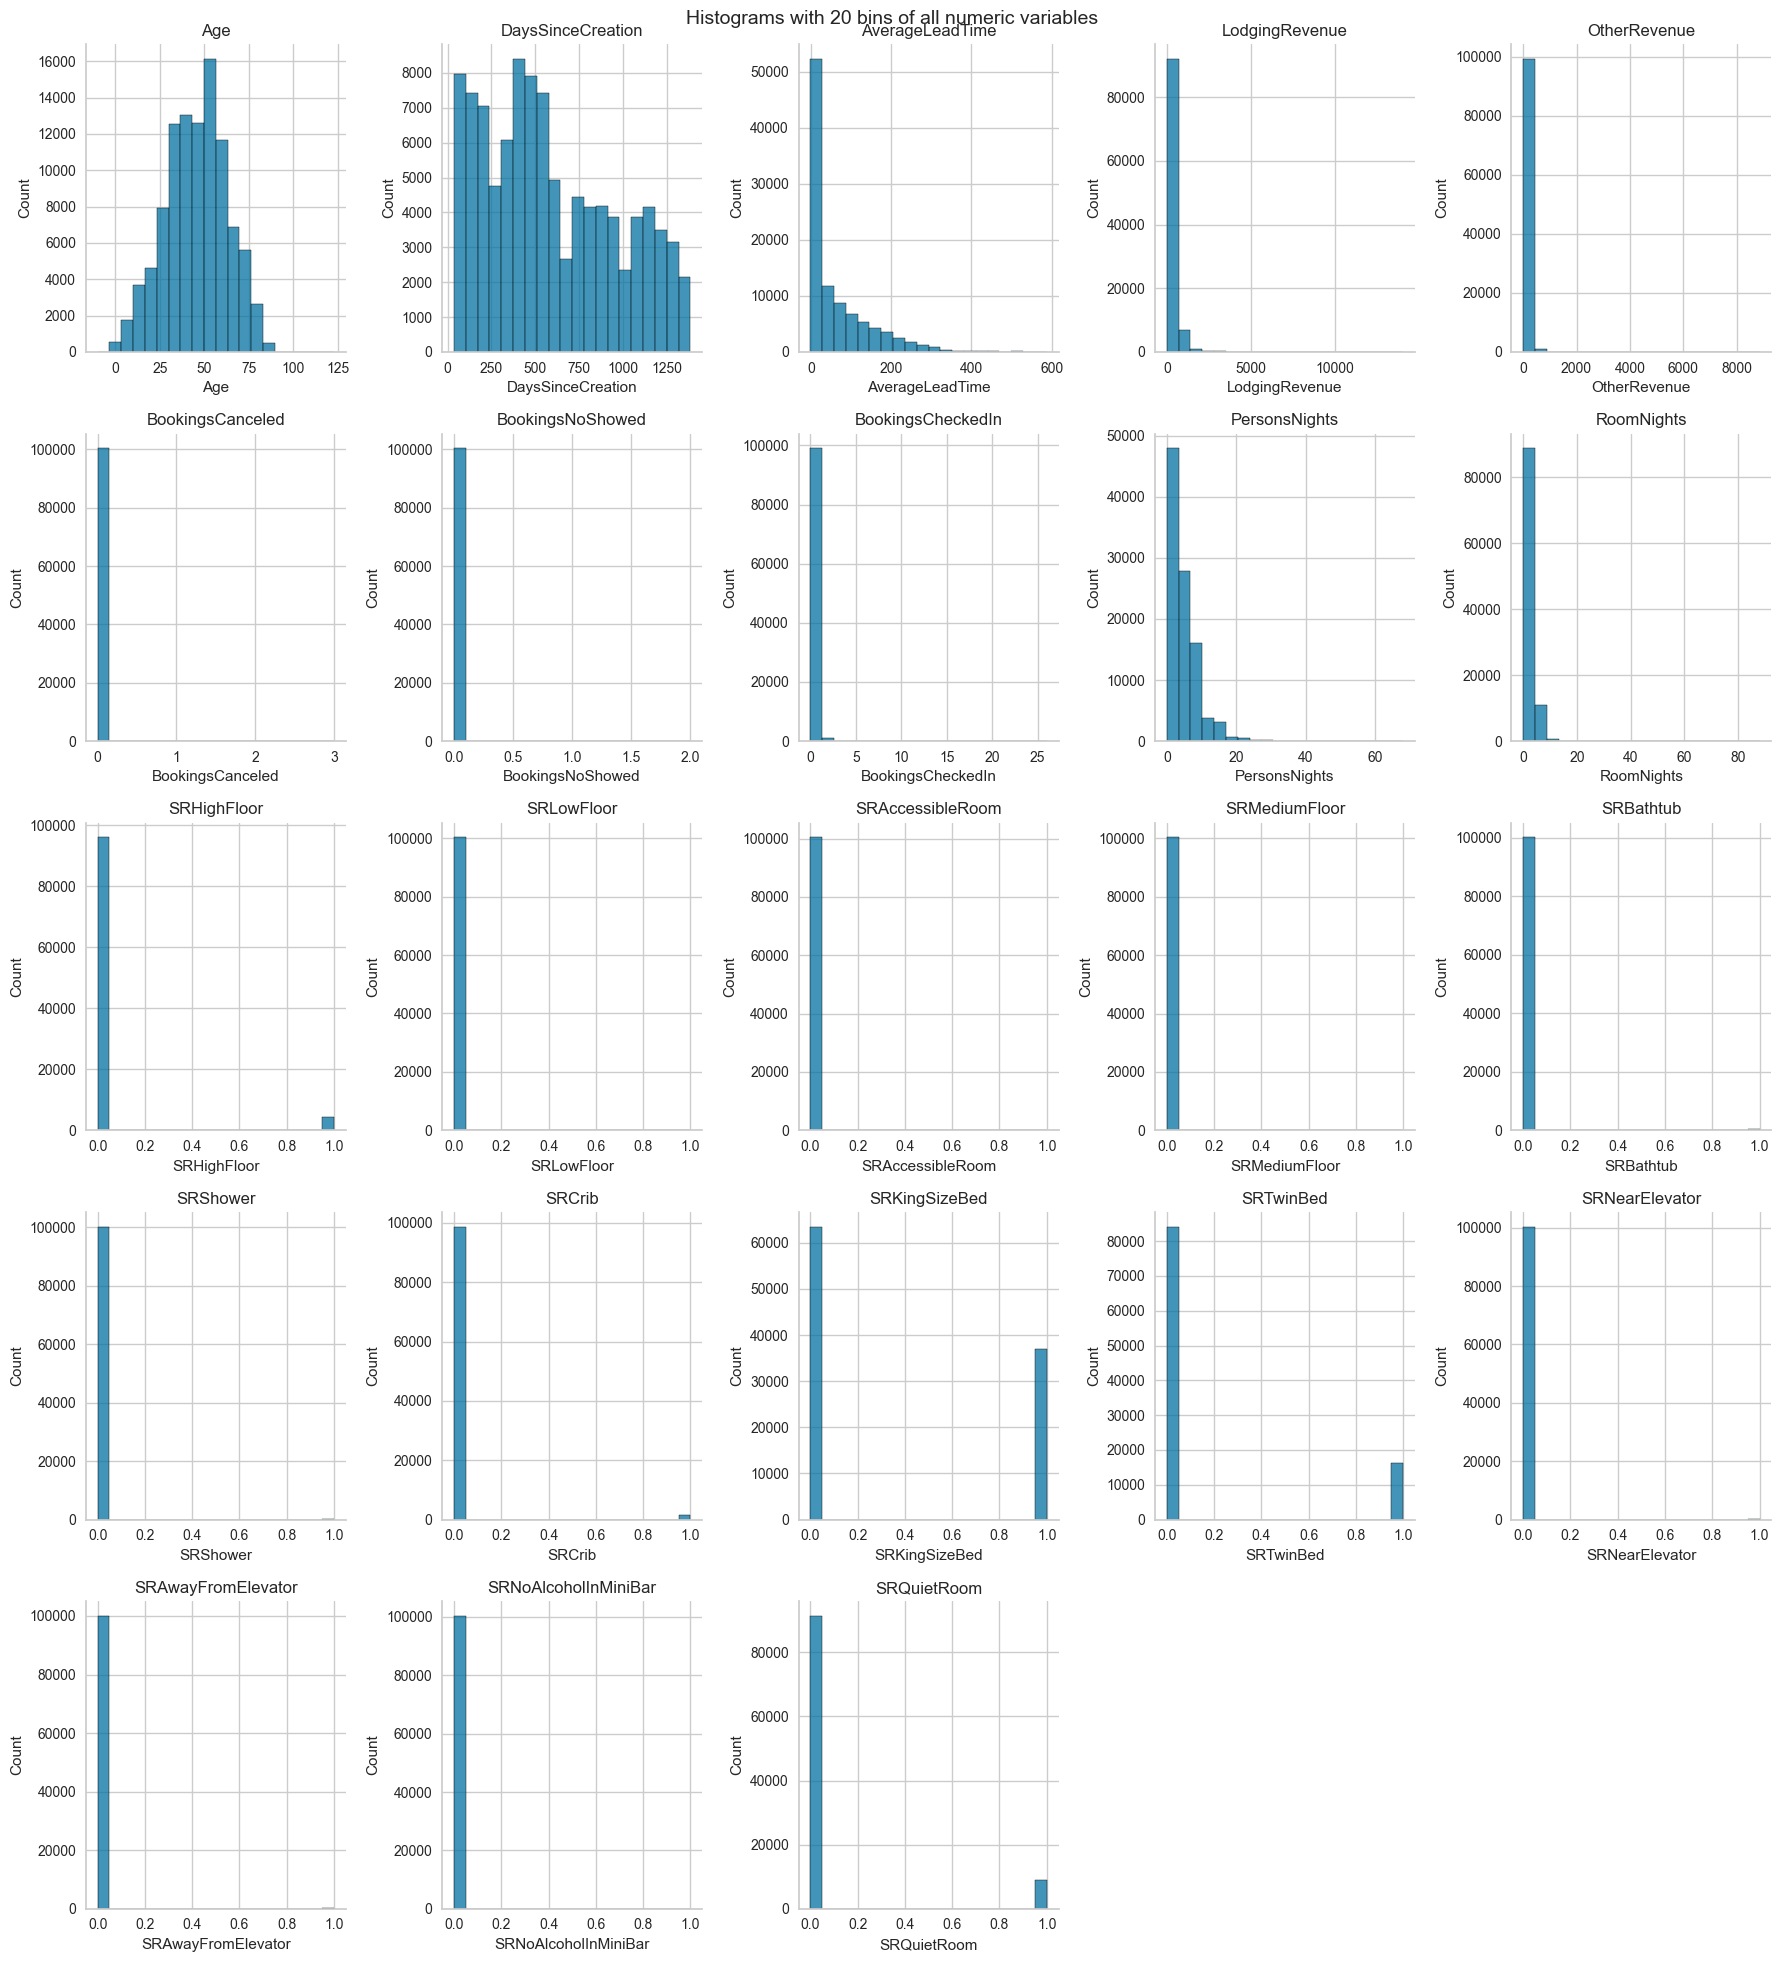

In [9]:
subPlots_label_fontSize = 12
plots_Title_fontSize = 14
numerical_data = data.select_dtypes(include=[np.number]).columns.tolist()
num_vars = len(numerical_data)
num_cols = 5
num_rows = (num_vars // num_cols) + (1 if num_vars % num_cols != 0 else 0)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
ax = ax.flatten()

for i, var in enumerate(numerical_data):
    sns.histplot(data=data,
                 bins=20,
                 x=var,
                 ax=ax[i],
                 kde=False)
    ax[i].set_title(var, fontsize=subPlots_label_fontSize)

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize)
plt.tight_layout()
plt.show()

__`Step 8`__ Boxplot of numeric variables

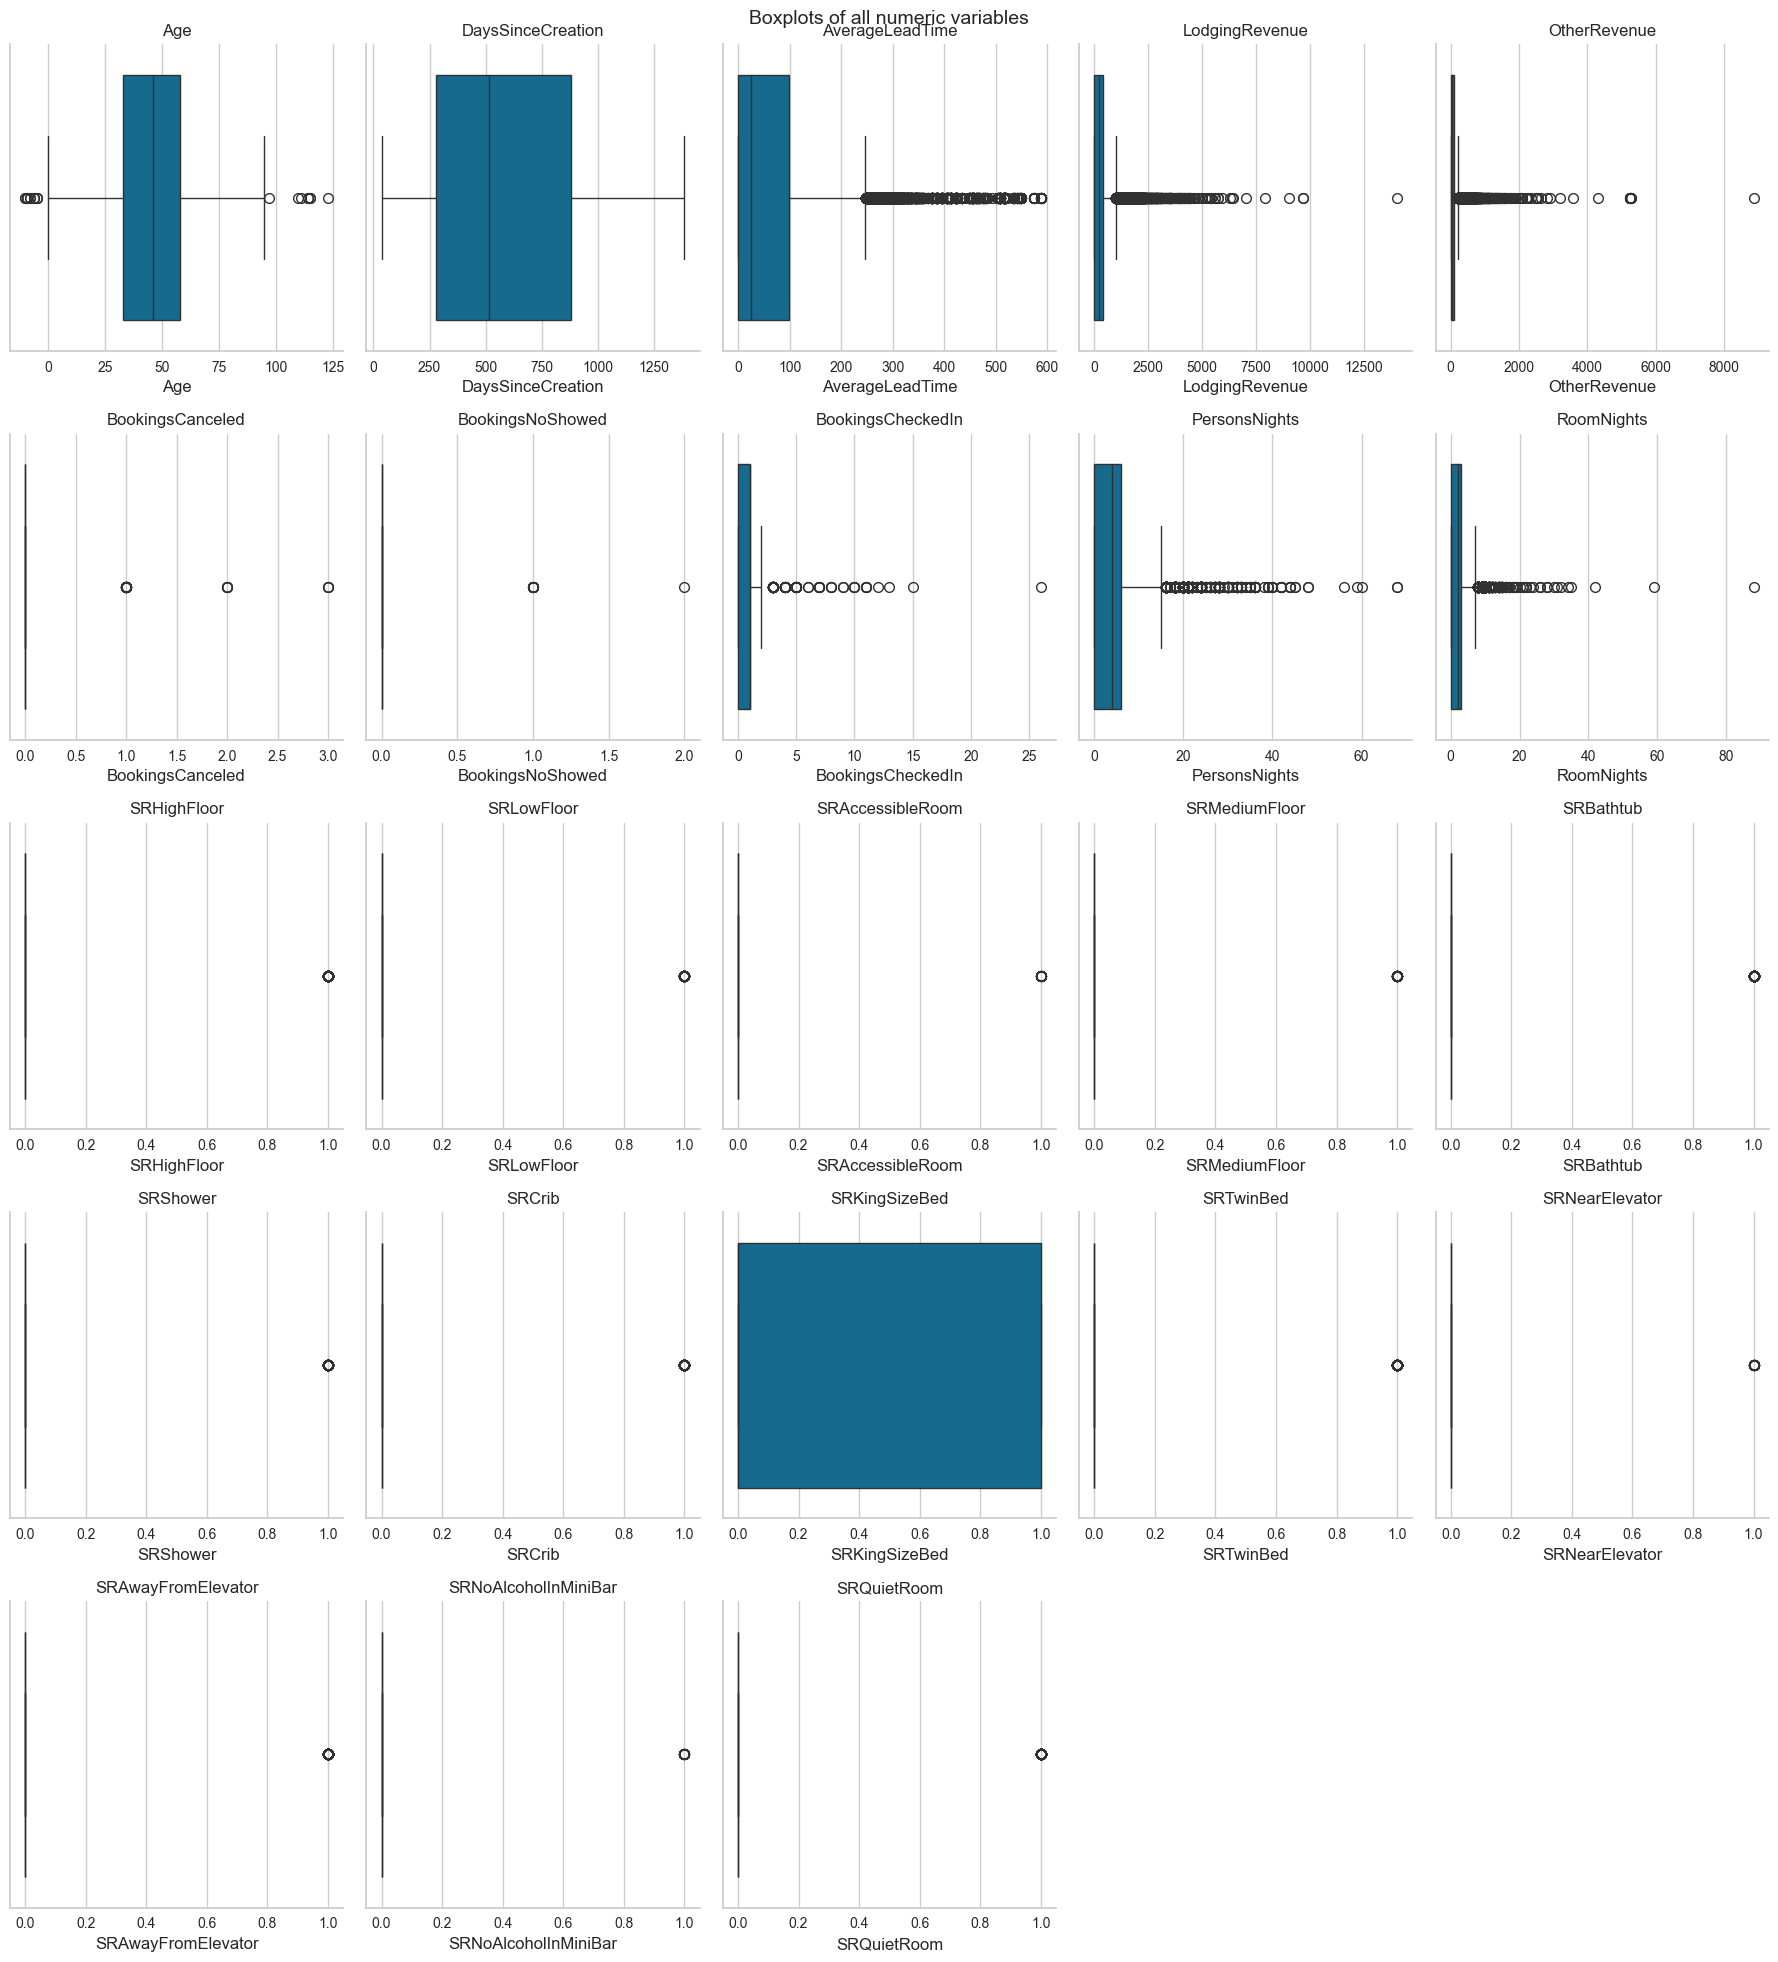

In [10]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
ax = ax.flatten()

for i, var in enumerate(numerical_data):
    sns.boxplot(data=data, x=var, ax=ax[i])
    ax[i].set_title(var, fontsize=subPlots_label_fontSize)

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

sns.despine()
fig.suptitle("Boxplots of all numeric variables", fontsize=plots_Title_fontSize)
plt.tight_layout()
plt.show()

__`Step 9`__ Check if the Customer Preferences have only binary values (0 or 1)

In [11]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]

data[binary_cols] = data[binary_cols].apply(pd.to_numeric, errors='coerce')

In [12]:
for col in binary_cols:
    unique_values = data[col].unique()
    if not set(unique_values).issubset({0, 1}):
        print(f"Column {col} contains values other than 0 and 1: {unique_values}")

__`Step 10`__ Distribution of the variables with binary values (0 or 1)

In [13]:
for col in binary_cols:
    print(f"Value counts for {col}:")
    print(data[col].value_counts(dropna=False))
    print("-" * 40)

Value counts for SRHighFloor:
SRHighFloor
0    96030
1     4365
Name: count, dtype: int64
----------------------------------------
Value counts for SRLowFloor:
SRLowFloor
0    100260
1       135
Name: count, dtype: int64
----------------------------------------
Value counts for SRMediumFloor:
SRMediumFloor
0    100330
1        65
Name: count, dtype: int64
----------------------------------------
Value counts for SRAccessibleRoom:
SRAccessibleRoom
0    100376
1        19
Name: count, dtype: int64
----------------------------------------
Value counts for SRBathtub:
SRBathtub
0    100065
1       330
Name: count, dtype: int64
----------------------------------------
Value counts for SRShower:
SRShower
0    100228
1       167
Name: count, dtype: int64
----------------------------------------
Value counts for SRCrib:
SRCrib
0    98735
1     1660
Name: count, dtype: int64
----------------------------------------
Value counts for SRKingSizeBed:
SRKingSizeBed
0    63518
1    36877
Name: count, 

__`Step 11`__ Distribution of the categorical variables

In [14]:
categorical_cols = ["Nationality", "DistributionChannel"]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [15]:
nationality_cols = [col for col in data.columns if col.startswith("Nationality_")]
nationality_counts = data[nationality_cols].sum().sort_values(ascending=False)
distribution_cols = [col for col in data.columns if col.startswith("DistributionChannel_")]
distribution_counts = data[distribution_cols].sum().sort_values(ascending=False)

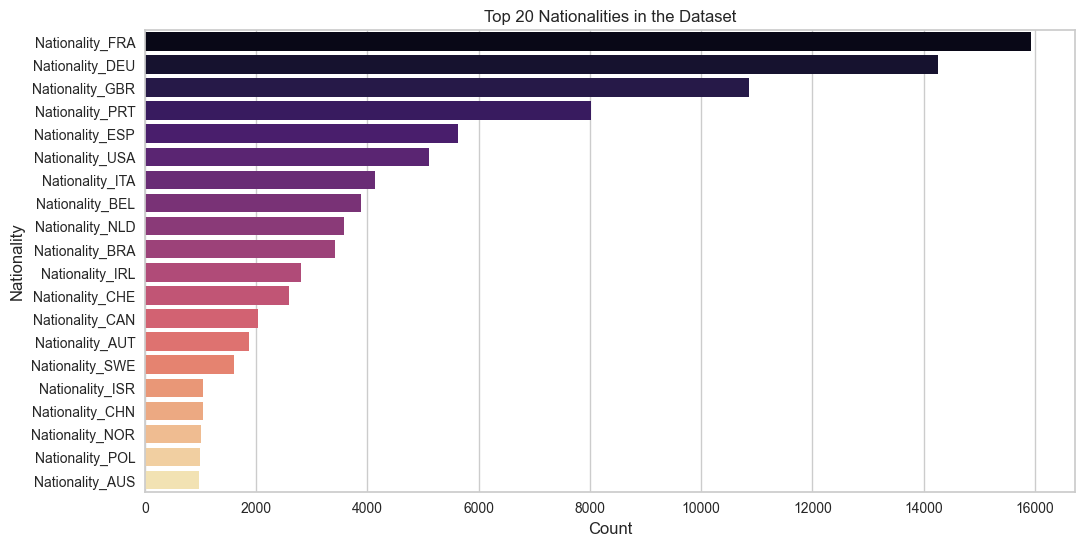

In [16]:
top_n = 20
top_nationalities = nationality_counts.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_nationalities.values, y=top_nationalities.index, palette="magma")
plt.title(f"Top {top_n} Nationalities in the Dataset")
plt.xlabel("Count")
plt.ylabel("Nationality")
plt.show()

In [17]:
data[nationality_cols] = data[nationality_cols].astype(int)

In [18]:
threshold = len(data) * 0.05
nationality_counts = data[nationality_cols].sum()
top_nationalities = nationality_counts[nationality_counts > threshold].index.tolist()
data["Nationality_Processed"] = data[top_nationalities].idxmax(axis=1)
data["Nationality_Processed"] = data["Nationality_Processed"].fillna("Other")
data["Nationality_Processed"] = data["Nationality_Processed"].astype("category")
data.drop(columns=nationality_cols, inplace=True)

print(data["Nationality_Processed"].value_counts())

Nationality_Processed
Nationality_DEU    54854
Nationality_FRA    15921
Nationality_GBR    10866
Nationality_PRT     8019
Nationality_ESP     5632
Nationality_USA     5103
Name: count, dtype: int64


C:\Users\jgven\AppData\Local\Temp\ipykernel_21240\3475910094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["Nationality_Processed"] = data[top_nationalities].idxmax(axis=1)


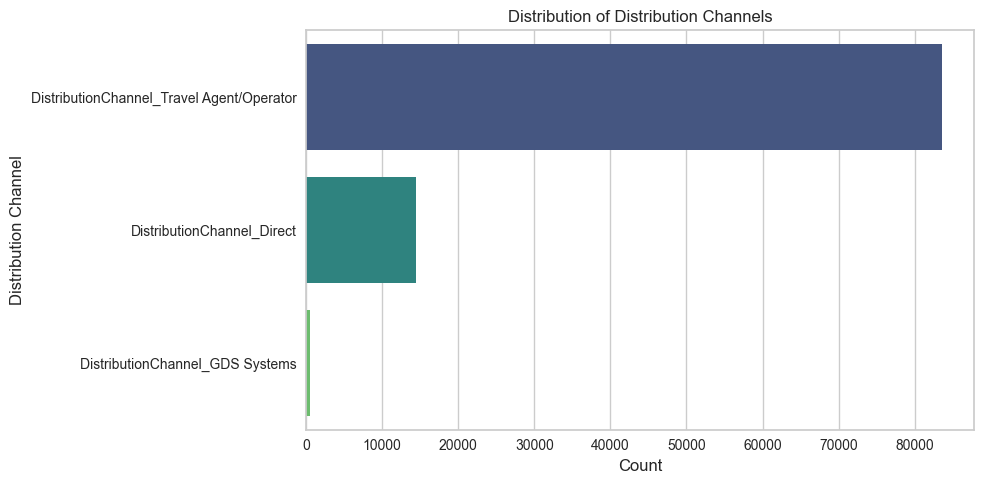

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(x=distribution_counts.values, y=distribution_counts.index, palette="viridis", ax=ax)
ax.set_title("Distribution of Distribution Channels")
ax.set_xlabel("Count")
ax.set_ylabel("Distribution Channel")

plt.tight_layout()
plt.show()

In [20]:
bool_cols = ['DistributionChannel_Direct', 'DistributionChannel_GDS Systems', 'DistributionChannel_Travel Agent/Operator']
data[bool_cols] = data[bool_cols].astype(int)

In [21]:
print(data['BookingsNoShowed'].value_counts())

BookingsNoShowed
0    100385
1         9
2         1
Name: count, dtype: int64


In [22]:
print(data['BookingsCheckedIn'].value_counts())

BookingsCheckedIn
1     68554
0     30502
2      1190
3        95
4        16
5        15
7         5
11        4
8         3
10        3
6         2
9         2
12        1
26        1
13        1
15        1
Name: count, dtype: int64


Since the BookingsNoShowed variable is highly imbalanced, we can simplify it into a binary feature:

- 0 → Never No-Showed
- 1 or more → At Least One No-Show

In [23]:
data["HasNoShow"] = (data["BookingsNoShowed"] > 0).astype(int)

Since almost all customers have 0 canceled bookings, we can simplify it:

- 0 → Never canceled
- 1 or more → At least one cancellation

In [24]:
data["HasCanceled"] = (data["BookingsCanceled"] > 0).astype(int)

Since BookingsCheckedIn is right-skewed, a log transformation can make it more normally distributed:

# Remove people without ever Checking in

In [25]:
# Remover linhas onde 'BookingsCheckedIn' é 0
data = data[data['BookingsCheckedIn'] != 0]

print(f"Final dataset size after removing rows with BookingsCheckedIn = 0: {data.shape[0]} rows")


Final dataset size after removing rows with BookingsCheckedIn = 0: 69893 rows


In [26]:
data["Log_BookingsCheckedIn"] = np.log1p(data["BookingsCheckedIn"])

In [27]:
data.drop(columns=["BookingsNoShowed", "BookingsCanceled", "BookingsCheckedIn"], inplace=True)

### Correlation Matrix

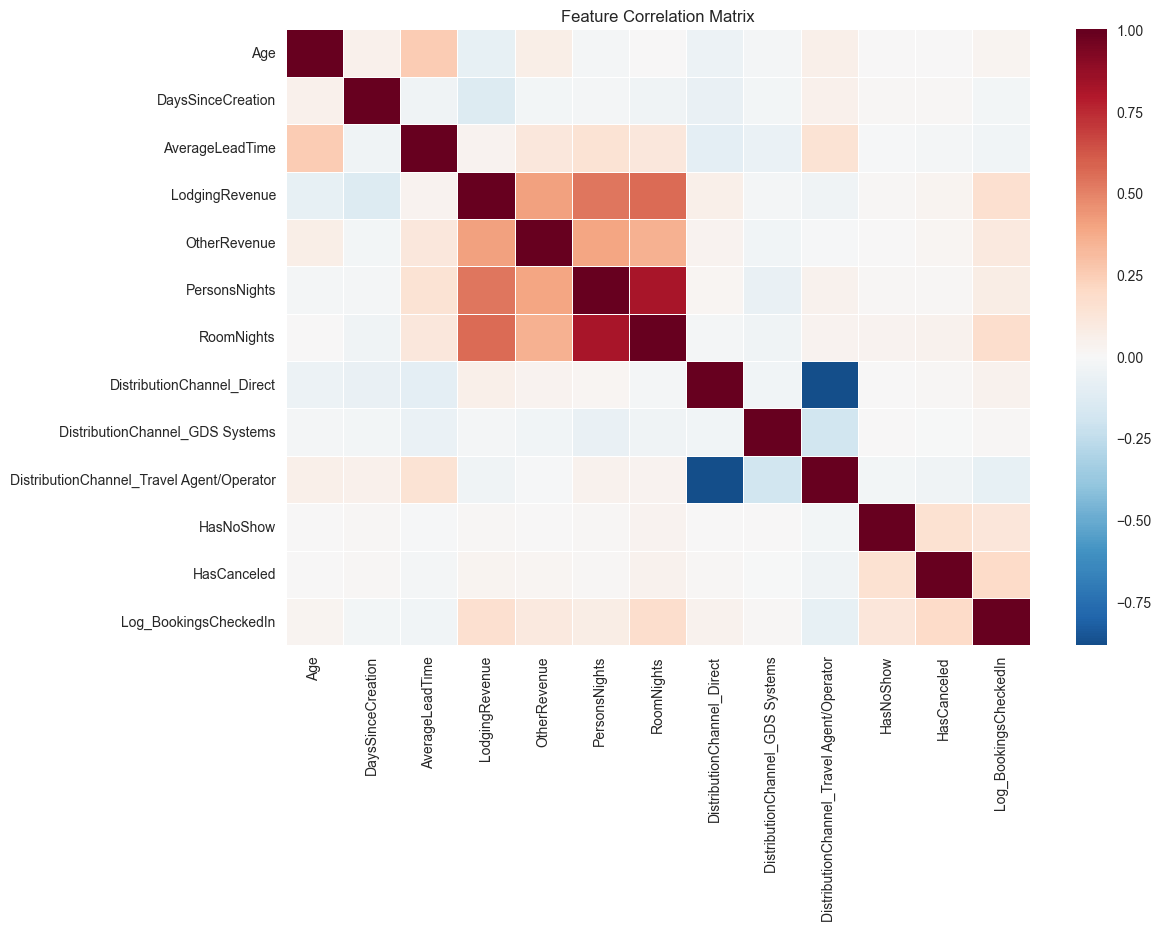

In [28]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
num_cols = [col for col in data.select_dtypes(include=["number"]).columns if col not in binary_cols]
corr_matrix = data[num_cols].corr()

plt.figure(figsize=(12, 8)) 
sns.heatmap(
    corr_matrix, 
    annot=False,  
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Matrix")
plt.show()

# Data Preparation

### Missing Values Handling

In [29]:
data['Age'] = data['Age'].fillna(data['Age'].median())

In [30]:
print(data.isnull().sum())

Age                                          0
DaysSinceCreation                            0
AverageLeadTime                              0
LodgingRevenue                               0
OtherRevenue                                 0
PersonsNights                                0
RoomNights                                   0
SRHighFloor                                  0
SRLowFloor                                   0
SRAccessibleRoom                             0
SRMediumFloor                                0
SRBathtub                                    0
SRShower                                     0
SRCrib                                       0
SRKingSizeBed                                0
SRTwinBed                                    0
SRNearElevator                               0
SRAwayFromElevator                           0
SRNoAlcoholInMiniBar                         0
SRQuietRoom                                  0
DistributionChannel_Direct                   0
DistributionC

Remove Negative Values

In [31]:
numerical_cols = data.select_dtypes(include=['number']).columns
data[numerical_cols] = data[numerical_cols].clip(lower=0)

In [32]:
negative_values = (data[numerical_cols] < 0).sum()
print("Negative values after correction:\n", negative_values)

Negative values after correction:
 Age                                          0
DaysSinceCreation                            0
AverageLeadTime                              0
LodgingRevenue                               0
OtherRevenue                                 0
PersonsNights                                0
RoomNights                                   0
SRHighFloor                                  0
SRLowFloor                                   0
SRAccessibleRoom                             0
SRMediumFloor                                0
SRBathtub                                    0
SRShower                                     0
SRCrib                                       0
SRKingSizeBed                                0
SRTwinBed                                    0
SRNearElevator                               0
SRAwayFromElevator                           0
SRNoAlcoholInMiniBar                         0
SRQuietRoom                                  0
DistributionChannel_Direc

### Outliers Handling

In [33]:
data = data[((data['Age'] >= 0) & (data['Age'] <= 100))]

Outliers in (PersonsNights < RoomNights)

In [34]:
invalid_rows = data[data['PersonsNights'] < data['RoomNights']]
data = data[data['PersonsNights'] >= data['RoomNights']]

print(f"Rows eliminated due to PersonsNights < RoomNights: {invalid_rows.shape[0]}")

Rows eliminated due to PersonsNights < RoomNights: 12


Cap and Log Transformation

In [35]:
data

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,PersonsNights,RoomNights,SRHighFloor,SRLowFloor,SRAccessibleRoom,...,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,DistributionChannel_Direct,DistributionChannel_GDS Systems,DistributionChannel_Travel Agent/Operator,Nationality_Processed,HasNoShow,HasCanceled,Log_BookingsCheckedIn
ID,,,,,,,,,,,,,,,,,,,,,
1,52.0,440,59,292.00,82.3,6,4,0,0,0,...,0,0,0,0,0,0,Nationality_PRT,0,1,1.098612
4,61.0,1385,93,240.00,60.0,10,5,0,0,0,...,0,0,0,0,0,1,Nationality_FRA,0,0,0.693147
6,55.0,1385,58,230.00,24.0,4,2,0,0,0,...,0,0,0,0,0,1,Nationality_DEU,0,0,0.693147
8,33.0,1385,38,535.00,94.0,10,5,0,0,0,...,0,0,0,0,0,1,Nationality_FRA,0,0,0.693147
10,26.0,1385,96,174.00,69.0,6,3,0,0,0,...,0,0,0,0,0,1,Nationality_DEU,0,0,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111725,60.0,37,43,875.00,167.8,10,5,1,0,0,...,0,0,0,0,0,1,Nationality_ESP,0,0,0.693147
111727,51.0,37,7,173.55,18.0,1,1,1,0,0,...,0,0,1,1,0,0,Nationality_PRT,0,0,0.693147
111728,34.0,36,41,98.00,14.0,2,1,0,0,0,...,0,0,0,0,0,1,Nationality_DEU,0,0,0.693147


In [36]:
zero_count = (data["LodgingRevenue"] == 0).sum()
print(f"Number of zero values in LodgingRevenue: {zero_count}")
zero_percentage = (data["LodgingRevenue"] == 0).mean() * 100
print(f"Percentage of zero values in LodgingRevenue: {zero_percentage:.2f}%")
other_zero_count = (data["OtherRevenue"] == 0).sum()
print(f"Number of zero values in OtherRevenue: {other_zero_count}")

Number of zero values in LodgingRevenue: 304
Percentage of zero values in LodgingRevenue: 0.44%
Number of zero values in OtherRevenue: 182


In [37]:
#data["HasLodgingRevenue"] = (data["LodgingRevenue"] > 0).astype(int)
#data["HasOtherRevenue"] = (data["OtherRevenue"] > 0).astype(int)

In [38]:
data["LodgingRevenue"] = data["LodgingRevenue"].clip(upper=6000)
data["OtherRevenue"] = data["OtherRevenue"].clip(upper=3000)
data["AverageLeadTime"] = data["AverageLeadTime"].clip(upper=300)
data["PersonsNights"] = data["PersonsNights"].clip(upper=35)
data["RoomNights"] = data["RoomNights"].clip(upper=30)

In [39]:
data["LodgingRevenue_Log"] = np.log1p(data["LodgingRevenue"])
data["OtherRevenue_Log"] = np.log1p(data["OtherRevenue"])
data["AverageLeadTime_Log"] = np.log1p(data["AverageLeadTime"])
data["PersonsNights_Log"] = np.log1p(data["PersonsNights"])
data["RoomNights_Log"] = np.log1p(data["RoomNights"])

In [40]:
data.drop(columns=["LodgingRevenue", "OtherRevenue", "AverageLeadTime", "PersonsNights", "RoomNights"], inplace=True)

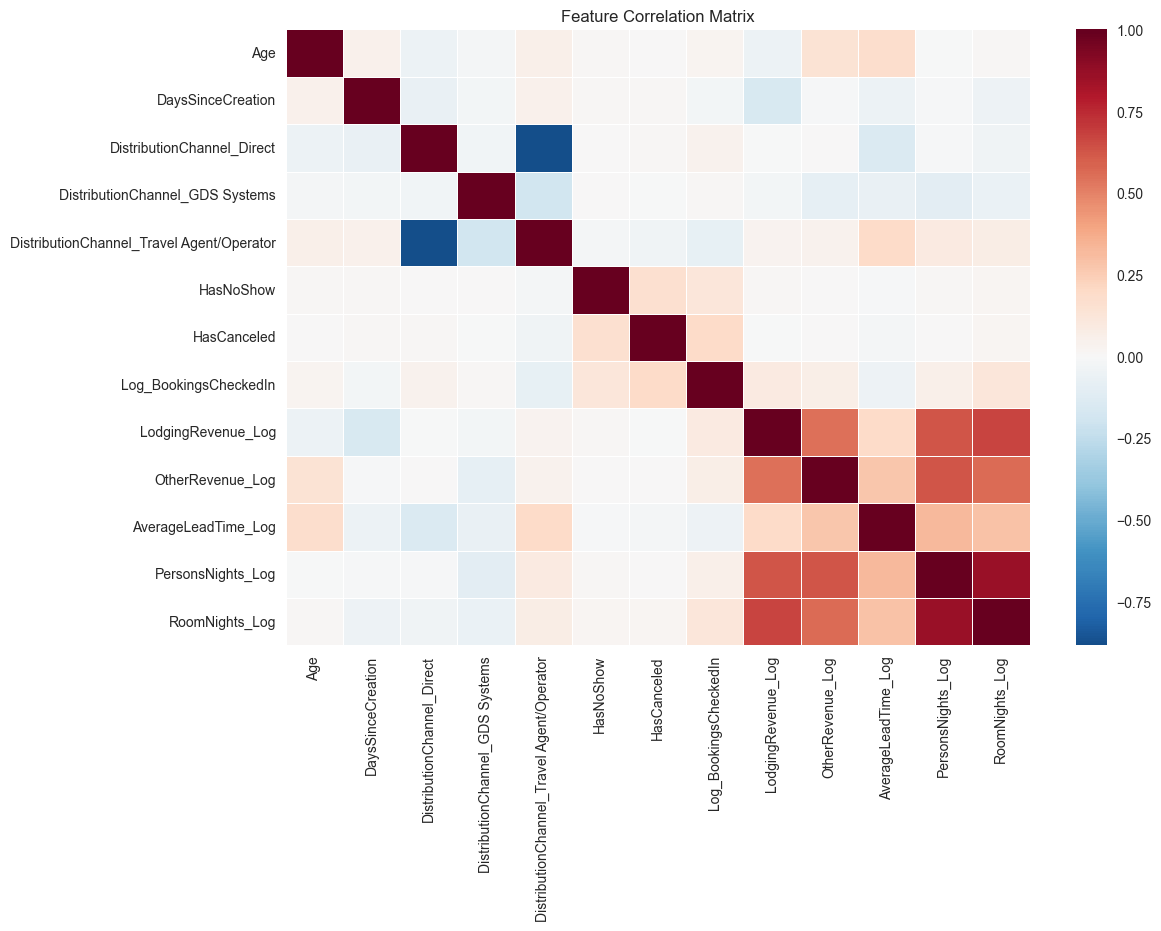

In [41]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
num_cols = [col for col in data.select_dtypes(include=["number"]).columns if col not in binary_cols]
corr_matrix = data[num_cols].corr()

plt.figure(figsize=(12, 8)) 
sns.heatmap(
    corr_matrix, 
    annot=False,  
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Matrix")
plt.show()

### Outliers Check

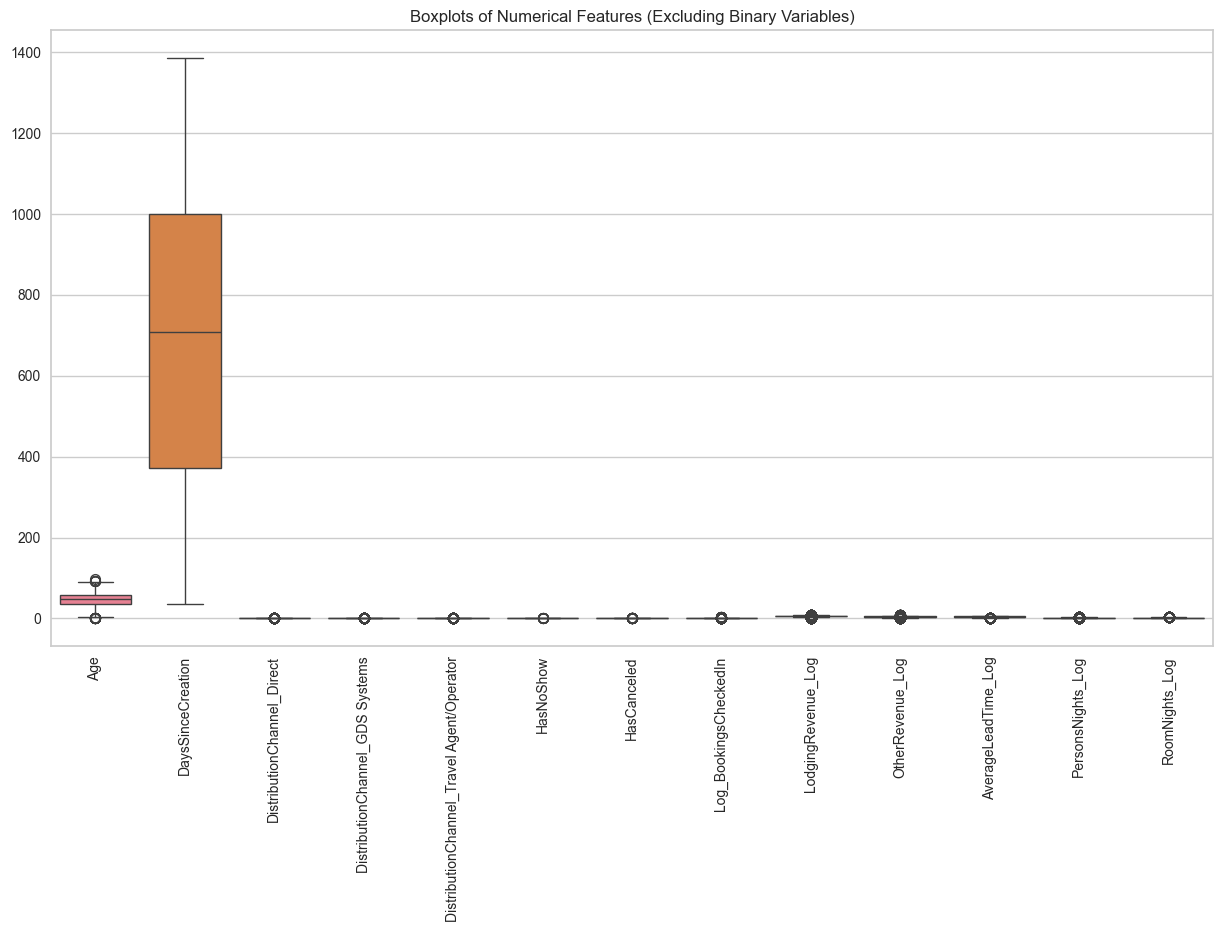

In [42]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
num_cols = [col for col in data.select_dtypes(include=["number"]).columns if col not in binary_cols]

plt.figure(figsize=(15, 8))
sns.boxplot(data=data[num_cols])
plt.xticks(rotation=90)
plt.title("Boxplots of Numerical Features (Excluding Binary Variables)")
plt.show()

### Merge Features based on the Correlation

In [43]:
data["TotalNights_Log"] = data["PersonsNights_Log"] + data["RoomNights_Log"]
data.drop(columns=["PersonsNights_Log", "RoomNights_Log"], inplace=True)

In [44]:
data["TotalRevenue_Log"] = data["LodgingRevenue_Log"] + data["OtherRevenue_Log"]
data.drop(columns=["LodgingRevenue_Log", "OtherRevenue_Log"], inplace=True)

In [45]:
drop_cols = [
    'SRHighFloor', 'SRLowFloor', 'SRAccessibleRoom', 'SRMediumFloor',
    'SRBathtub', 'SRShower', 'SRCrib', 'SRKingSizeBed', 'SRTwinBed',
    'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 'SRQuietRoom'
]

if "Nationality_Processed" in data.columns:
    data.drop(columns=["Nationality_Processed"], inplace=True)

data.drop(columns=drop_cols, inplace=True)
print("Final feature list:")
print(data.columns)
print("Total number of columns:", len(data.columns))

Final feature list:
Index(['Age', 'DaysSinceCreation', 'DistributionChannel_Direct',
       'DistributionChannel_GDS Systems',
       'DistributionChannel_Travel Agent/Operator', 'HasNoShow', 'HasCanceled',
       'Log_BookingsCheckedIn', 'AverageLeadTime_Log', 'TotalNights_Log',
       'TotalRevenue_Log'],
      dtype='object')
Total number of columns: 11


## 📌 Final Variables

- **`Age`** → Customer's age  
- **`DaysSinceCreation`** → Time since account creation  
- **`DistributionChannel_Direct`** → Whether the booking channel was direct (binary)  
- **`DistributionChannel_GDS Systems`** → Whether the booking was made through GDS systems (binary)  
- **`DistributionChannel_Travel Agent/Operator`** → Whether the booking was made via a travel agent or operator (binary)  
- **`HasNoShow`** → Whether the customer has had a no-show before (binary)  
- **`HasCanceled`** → Whether the customer has canceled a booking before (binary)  
- **`Log_BookingsCheckedIn`** → Number of successfully completed bookings (log-transformed)  
- **`HasLodgingRevenue`** → Whether the customer has generated lodging revenue (binary)  
- **`HasOtherRevenue`** → Whether the customer has generated other revenue (binary)  
- **`AverageLeadTime_Log`** → Average lead time before booking (log-transformed)  
- **`TotalNights_Log`** → Total nights booked (log-transformed)  
- **`TotalRevenue_Log`** → Total revenue generated by the customer (log-transformed)  

In [46]:
# List of binary columns to drop
binary_columns = [
    'HasNoShow',
    'HasCanceled'
]

# Drop the binary columns
data = data.drop(columns=binary_columns)

print(f"Data shape after dropping binary columns: {data.shape}")


Data shape after dropping binary columns: (69877, 9)


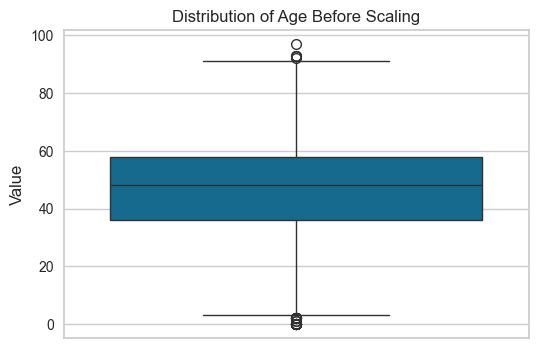

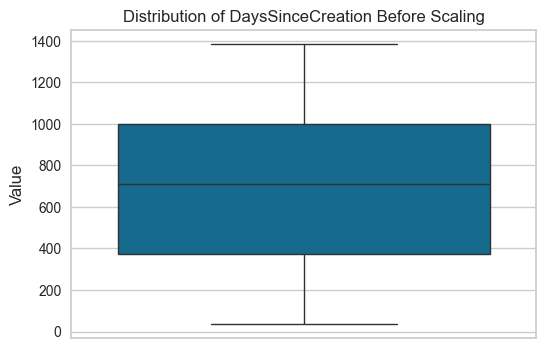

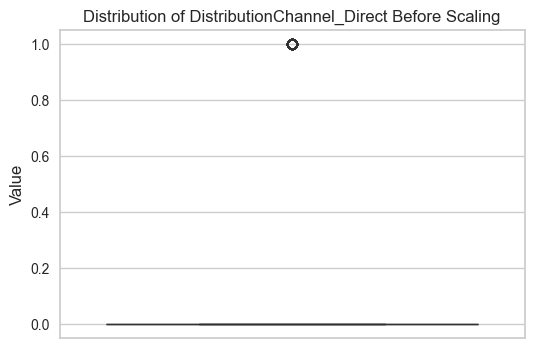

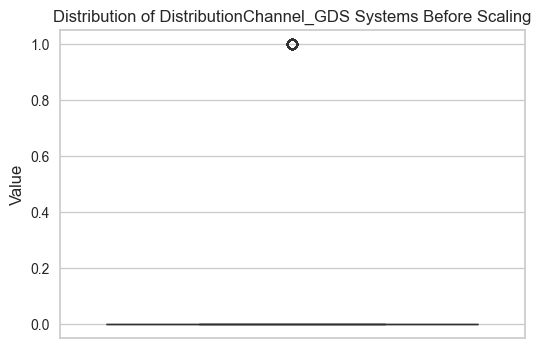

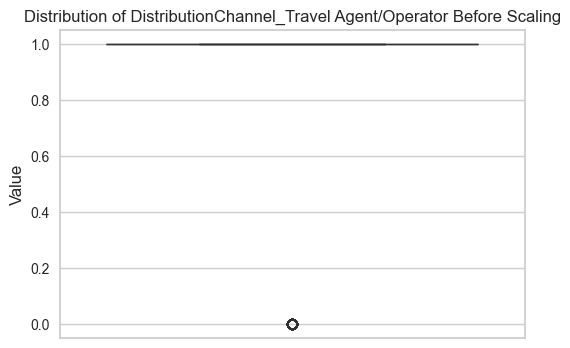

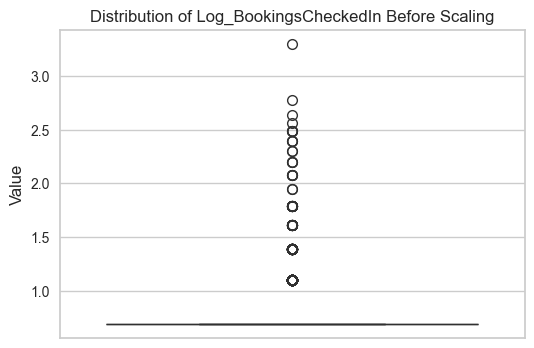

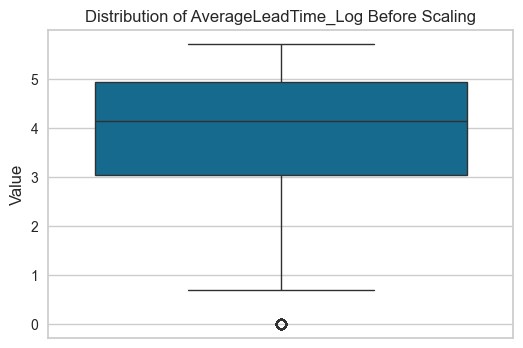

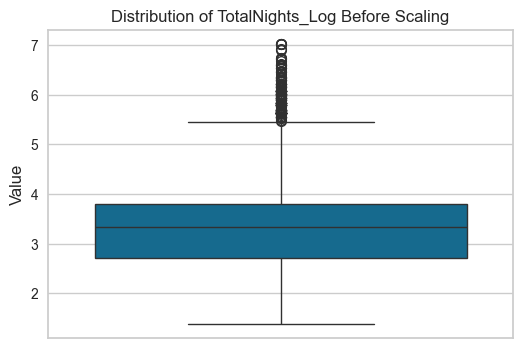

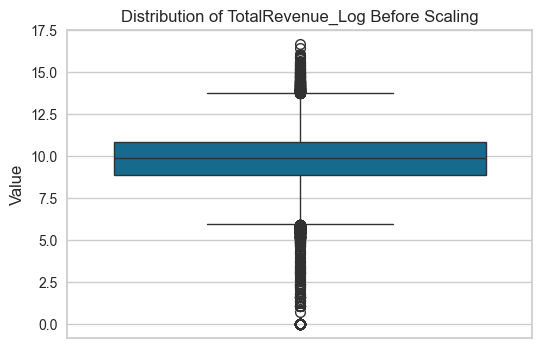

In [47]:
for column in data.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=data[column])
    plt.title(f"Distribution of {column} Before Scaling")
    plt.ylabel("Value")
    plt.show()

In [48]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Create different scalers
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler()
}

# Apply each scaler
scaled_dfs = {}
for name, scaler in scalers.items():
    scaled_data = scaler.fit_transform(data)
    scaled_dfs[name] = pd.DataFrame(scaled_data, columns=data.columns)

# Compare mean and variance
for name, df in scaled_dfs.items():
    print(f"\n{name} - Mean:\n{df.mean()}")
    print(f"\n{name} - Variance:\n{df.var()}")



MinMaxScaler - Mean:
Age                                          0.494845
DaysSinceCreation                            0.481183
DistributionChannel_Direct                   0.130329
DistributionChannel_GDS Systems              0.006955
DistributionChannel_Travel Agent/Operator    0.839303
Log_BookingsCheckedIn                        0.003362
AverageLeadTime_Log                          0.668493
TotalNights_Log                              0.320962
TotalRevenue_Log                             0.585955
dtype: float64

MinMaxScaler - Variance:
Age                                          0.024974
DaysSinceCreation                            0.077548
DistributionChannel_Direct                   0.113345
DistributionChannel_GDS Systems              0.006907
DistributionChannel_Travel Agent/Operator    0.134875
Log_BookingsCheckedIn                        0.000692
AverageLeadTime_Log                          0.063281
TotalNights_Log                              0.026808
TotalRevenue_Log   

In [49]:
print(data.columns)

Index(['Age', 'DaysSinceCreation', 'DistributionChannel_Direct',
       'DistributionChannel_GDS Systems',
       'DistributionChannel_Travel Agent/Operator', 'Log_BookingsCheckedIn',
       'AverageLeadTime_Log', 'TotalNights_Log', 'TotalRevenue_Log'],
      dtype='object')


### Min Max Scaling

In [50]:
scaler = StandardScaler()
min_max_data = scaler.fit_transform(data)
df_min_max_data = pd.DataFrame(min_max_data, columns=data.columns)

### PCA

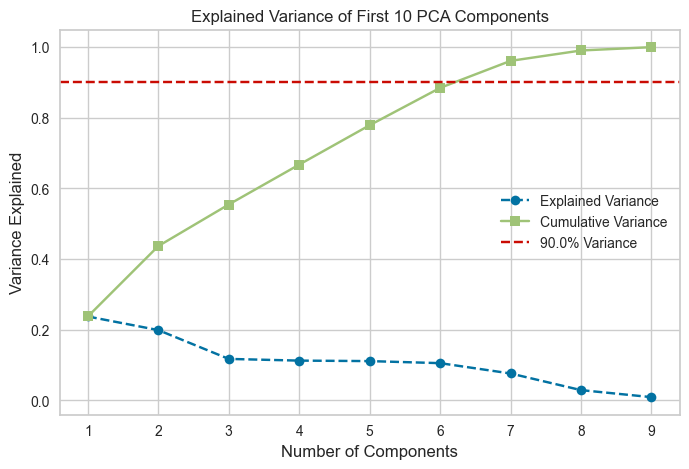

Total variance explained by 10 components: 1.0000


In [51]:
pca = PCA(n_components=9)
data_pca = pca.fit_transform(min_max_data)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label='Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', label='Cumulative Variance')

threshold_var = 0.90  
plt.axhline(y=threshold_var, color='r', linestyle='--', label=f'{threshold_var*100}% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance of First 10 PCA Components')
plt.legend()
plt.show()

total_variance = sum(explained_variance)
print(f"Total variance explained by 10 components: {total_variance:.4f}")
if total_variance < threshold_var:
    print(f"Warning: Less than {threshold_var*100}% variance is explained! Consider increasing n_components.")

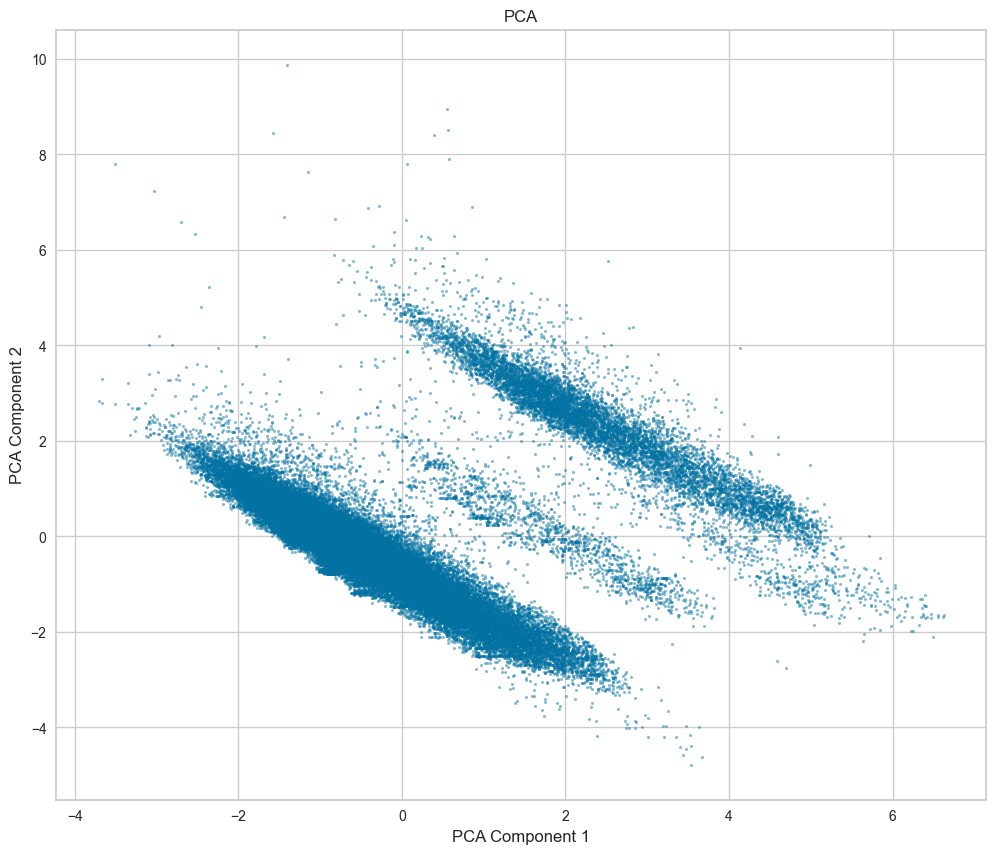

In [52]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(data_pca[:, 0], data_pca[:, 1], s=3, alpha=0.5)
ax.set_title(f"PCA")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
plt.show()

In [53]:
pca_columns = [f"PC{i+1}" for i in range(9)]
df_pca = pd.DataFrame(data_pca, columns=pca_columns)

print(df_pca.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.569799  2.286463  0.523790  2.638946  4.091889  2.211866  1.514115   
1 -1.147633 -0.186179 -1.449280 -0.185197  0.656952 -1.216944  0.153977   
2 -0.046335 -1.254082 -1.299548 -0.246196  0.657296 -0.913078  0.447475   
3 -0.958944  0.089774  0.173454 -0.973058  1.010402 -1.845152  0.182277   
4 -0.397831 -0.662478  0.185150 -1.006564  0.715496 -1.587373  1.250835   

        PC8       PC9  
0  0.029385  1.725782  
1  0.752985 -0.000599  
2 -0.016703 -0.062279  
3  0.137039 -0.022186  
4 -0.028317 -0.037131  


### Check if Clusters Exist (PCA)

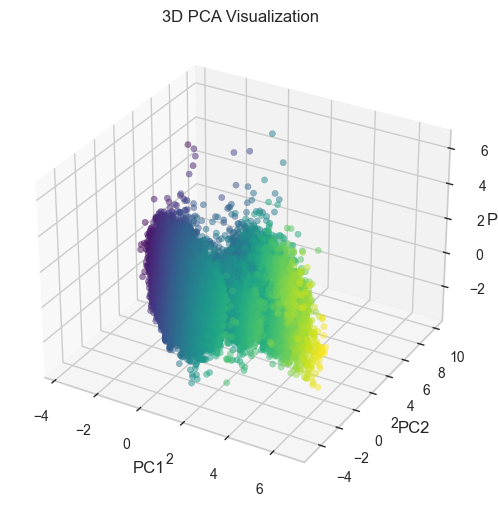

PCA Reduced Data Shape: (69877, 9)


In [54]:
pca_3d = PCA(n_components=3)
data_pca_3d = pca_3d.fit_transform(min_max_data)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], c=data_pca_3d[:, 0], cmap='viridis', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Visualization')
plt.show()

print(f"PCA Reduced Data Shape: {data_pca.shape}")

### UMAP

C:\Users\jgven\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


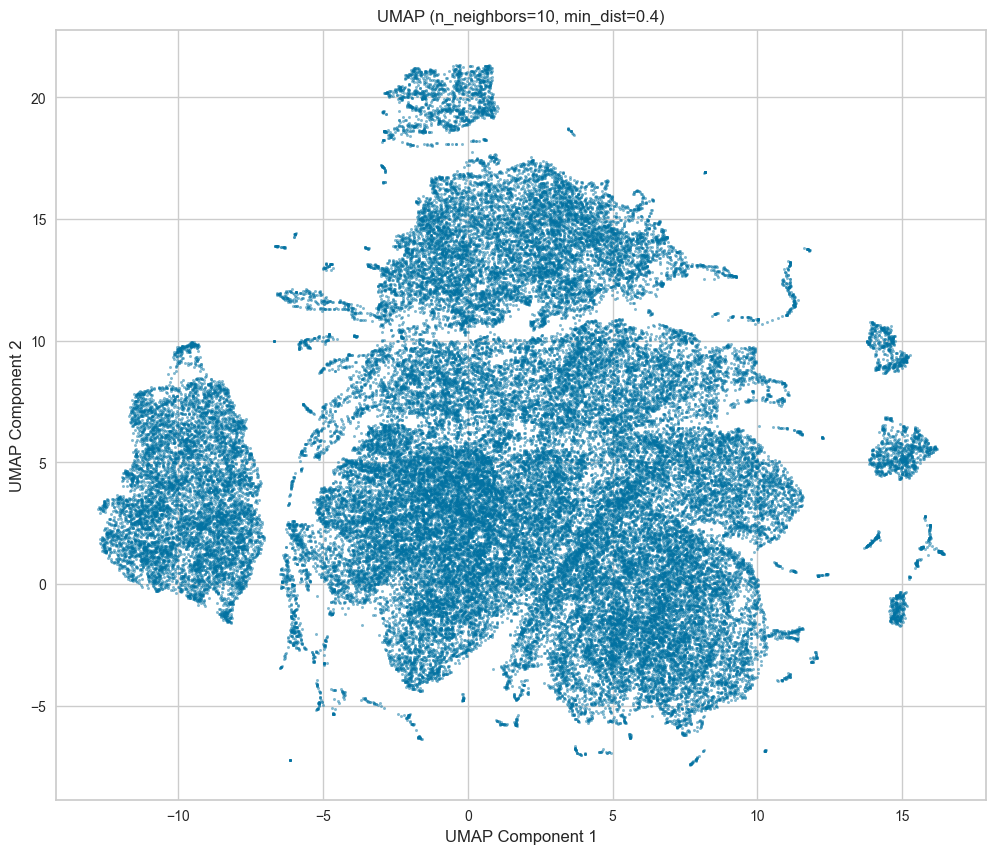

In [55]:
n_neighbors = 10
min_dist = 0.4
umap_reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=123)
data_umap = umap_reducer.fit_transform(min_max_data)

fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(data_umap[:, 0], data_umap[:, 1], s=3, alpha=0.5)
ax.set_title(f"UMAP (n_neighbors={n_neighbors}, min_dist={min_dist})")
ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
plt.show()

In [56]:
"""umap_reducer_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=123)
data_umap_3d = umap_reducer_3d.fit_transform(min_max_data)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap_3d[:, 0], data_umap_3d[:, 1], data_umap_3d[:, 2], c=data_umap_3d[:, 0], cmap='viridis', alpha=0.5)
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
ax.set_title('3D UMAP Visualization')
plt.show()"""

"umap_reducer_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=123)\ndata_umap_3d = umap_reducer_3d.fit_transform(min_max_data)\n\nfig = plt.figure(figsize=(8, 6))\nax = fig.add_subplot(111, projection='3d')\nax.scatter(data_umap_3d[:, 0], data_umap_3d[:, 1], data_umap_3d[:, 2], c=data_umap_3d[:, 0], cmap='viridis', alpha=0.5)\nax.set_xlabel('UMAP Component 1')\nax.set_ylabel('UMAP Component 2')\nax.set_zlabel('UMAP Component 3')\nax.set_title('3D UMAP Visualization')\nplt.show()"

### Comparing PCA and UMAP

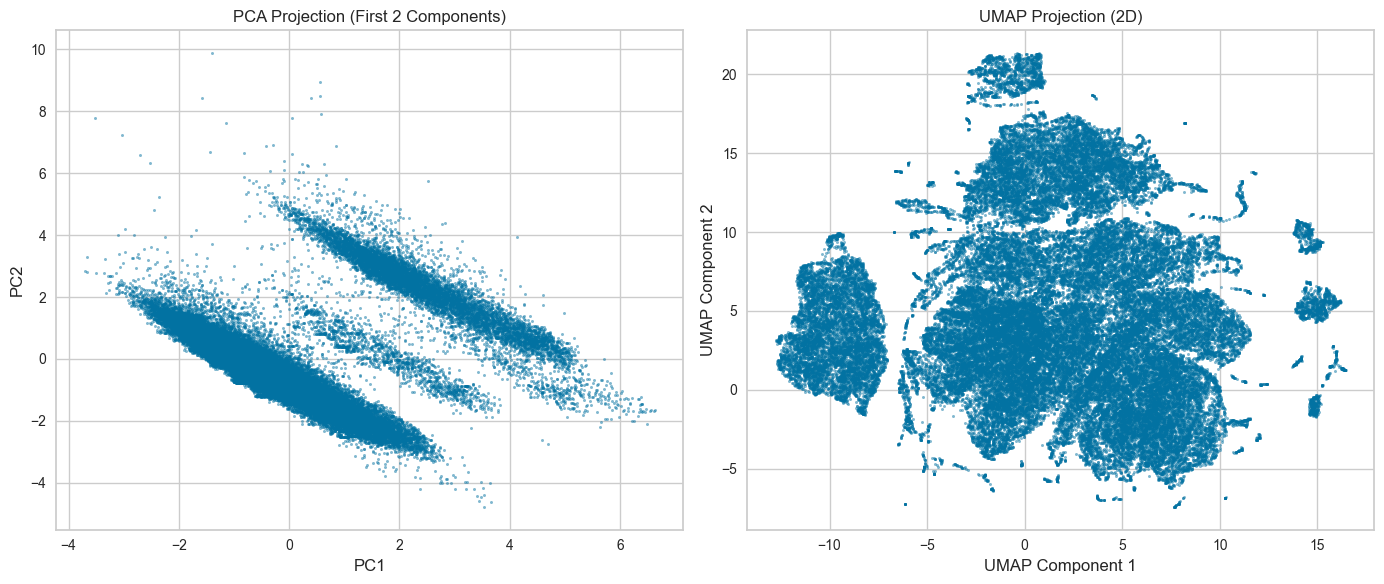

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA Scatter Plot
axes[0].scatter(data_pca[:, 0], data_pca[:, 1], s=3, alpha=0.5)
axes[0].set_title("PCA Projection (First 2 Components)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# UMAP Scatter Plot
axes[1].scatter(data_umap[:, 0], data_umap[:, 1], s=3, alpha=0.5)
axes[1].set_title("UMAP Projection (2D)")
axes[1].set_xlabel("UMAP Component 1")
axes[1].set_ylabel("UMAP Component 2")

plt.tight_layout()
plt.show()

# Clustering

### K-Means

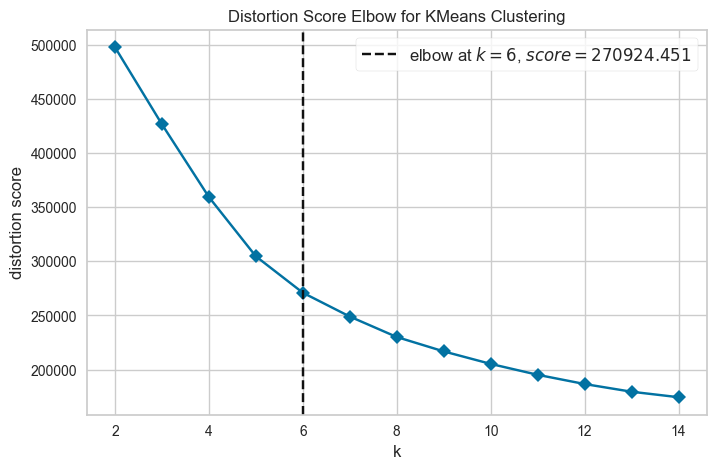

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
kmeans = KMeans(random_state=123, n_init=10)
plt.figure(figsize=(8, 5))
visualizer = KElbowVisualizer(kmeans, k=(2, 15), metric='distortion', timings=False)
visualizer.fit(min_max_data)
visualizer.show()

In [59]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=123, n_init=10)
df_min_max_data["Cluster"] = kmeans.fit_predict(df_min_max_data)

print(df_min_max_data["Cluster"].value_counts())
data["Cluster"] = df_min_max_data["Cluster"]
data.head()

Cluster
0    21651
2    21625
1    15973
4     8826
5     1317
3      485
Name: count, dtype: int64


,Age,DaysSinceCreation,DistributionChannel_Direct,DistributionChannel_GDS Systems,DistributionChannel_Travel Agent/Operator,Log_BookingsCheckedIn,AverageLeadTime_Log,TotalNights_Log,TotalRevenue_Log,Cluster
ID,,,,,,,,,,
1,52.0,440,0,0,0,1.098612,4.094345,3.555348,10.102621,0.0
4,61.0,1385,0,0,1,0.693147,4.543295,4.189655,9.595671,2.0
6,55.0,1385,0,0,1,0.693147,4.077537,2.708050,8.661294,4.0
8,33.0,1385,0,0,1,0.693147,3.663562,4.189655,10.838011,0.0
10,26.0,1385,0,0,1,0.693147,4.574711,3.332205,9.413281,4.0


In [60]:
silhouette_score_minmax = silhouette_score(df_min_max_data.drop(columns=["Cluster"]), df_min_max_data["Cluster"])
print(f"Silhouette Score: {silhouette_score_minmax:.4f}")

Silhouette Score: 0.2107


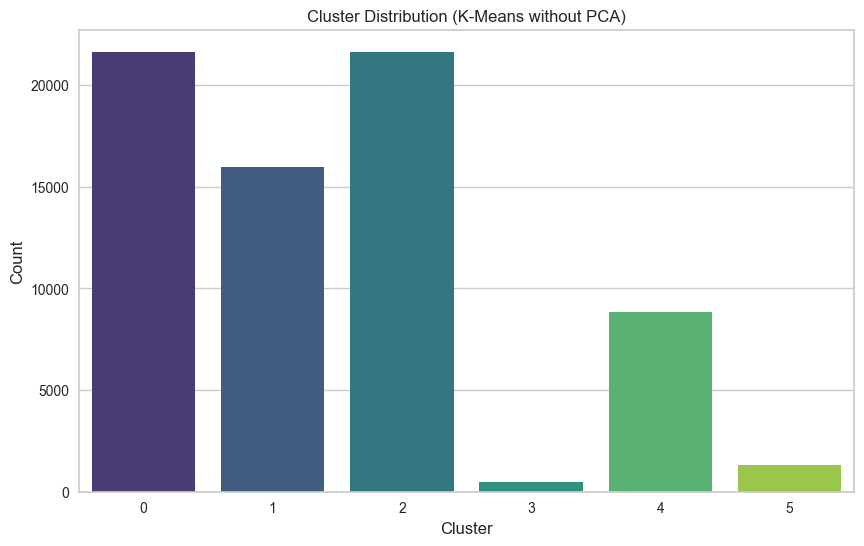

In [61]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df_min_max_data["Cluster"], palette="viridis")
plt.title("Cluster Distribution (K-Means without PCA)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

In [62]:
cluster_means = data.groupby("Cluster").mean()
print(cluster_means)

               Age  DaysSinceCreation  DistributionChannel_Direct  \
Cluster                                                             
0.0      48.173231         942.013372                    0.113391   
1.0      48.924340         908.492255                    0.118894   
2.0      48.215132         793.134658                    0.125662   
3.0      47.917178         784.828221                    0.119632   
4.0      48.223921         829.960020                    0.122795   
5.0      47.595519         786.805425                    0.135613   

         DistributionChannel_GDS Systems  \
Cluster                                    
0.0                             0.004702   
1.0                             0.004936   
2.0                             0.006904   
3.0                             0.006135   
4.0                             0.006047   
5.0                             0.010613   

         DistributionChannel_Travel Agent/Operator  Log_BookingsCheckedIn  \
Cluster          

### K-Means with PCA

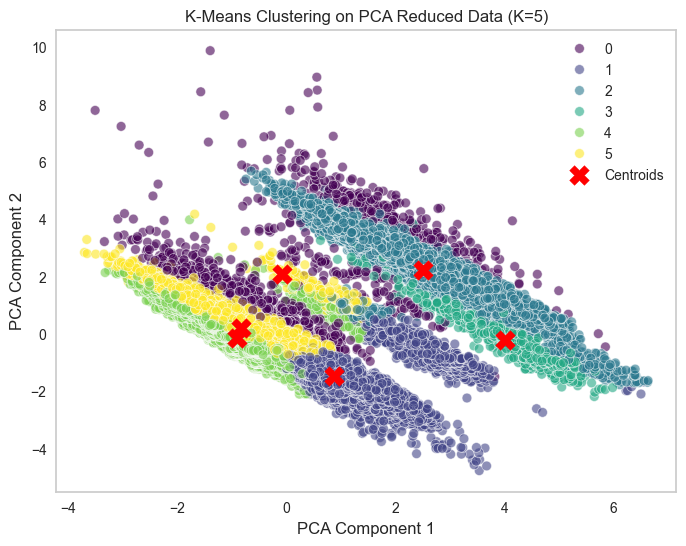

Cluster Distribution: {0: 1317, 1: 15869, 2: 8906, 3: 485, 4: 21576, 5: 21724}


In [63]:
n_pca_components = 6
pca = PCA(n_components=n_pca_components)
data_pca = pca.fit_transform(min_max_data)
kmeans_pca = KMeans(n_clusters=6, random_state=123, n_init=10)
y_kmeans_pca = kmeans_pca.fit_predict(data_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=y_kmeans_pca, palette="viridis", alpha=0.6)
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], s=200, c="red", marker="X", label="Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering on PCA Reduced Data (K=5)")
plt.legend()
plt.grid()
plt.show()

unique, counts = np.unique(y_kmeans_pca, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f"Cluster Distribution: {cluster_distribution}")

In [64]:
silhouette_avg = silhouette_score(data_pca, y_kmeans_pca)
print(f"Silhouette Score with PCA: {silhouette_avg:.4f}")

Silhouette Score with PCA: 0.2617


In [65]:
pca_cluster_means = pd.DataFrame(kmeans_pca.cluster_centers_, columns=[f"PC{i+1}" for i in range(n_pca_components)])
print(pca_cluster_means)

        PC1       PC2       PC3       PC4       PC5       PC6
0 -0.081810  2.081044  0.773369  2.633550  5.144699  2.246539
1  0.872251 -1.493573  0.159998 -0.180816  0.180358  0.159166
2  2.495529  2.239586 -0.519191 -0.536152 -0.351569  0.056542
3  4.009030 -0.223387  2.540922  9.280827 -2.459724 -6.009812
4 -0.916919 -0.157299 -0.842297  0.275850 -0.133028  0.016153
5 -0.836416  0.209810  0.829120 -0.288831 -0.112838 -0.157845


### K-Means with UMAP

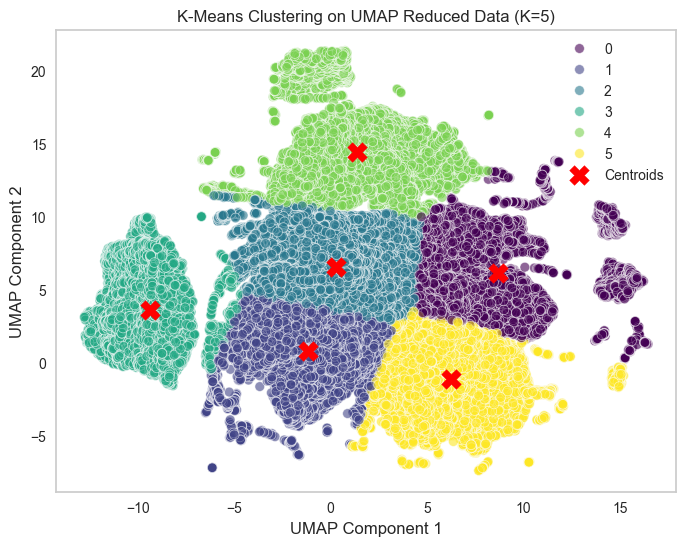

Cluster Distribution: {0: 9859, 1: 12398, 2: 11922, 3: 9459, 4: 12431, 5: 13808}


In [66]:
kmeans_umap = KMeans(n_clusters=6, random_state=123, n_init=10)
y_kmeans_umap = kmeans_umap.fit_predict(data_umap)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=y_kmeans_umap, palette="viridis", alpha=0.6)
plt.scatter(kmeans_umap.cluster_centers_[:, 0], kmeans_umap.cluster_centers_[:, 1], s=200, c="red", marker="X", label="Centroids")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("K-Means Clustering on UMAP Reduced Data (K=5)")
plt.legend()
plt.grid()
plt.show()

unique, counts = np.unique(y_kmeans_umap, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f"Cluster Distribution: {cluster_distribution}")

In [67]:
# Garantir que a coluna 'Cluster_UMAP' está presente antes de calcular a média
if "Cluster_UMAP" not in df_min_max_data.columns:
    # Se não existir, adicione a coluna "Cluster_UMAP" com base no K-Means em UMAP
    kmeans_umap = KMeans(n_clusters=6, random_state=123, n_init=10)
    df_min_max_data["Cluster_UMAP"] = kmeans_umap.fit_predict(data_umap)

In [68]:
# Garantir que apenas as features relevantes são usadas para calcular as médias
columns_to_exclude = ["Cluster", "Cluster_UMAP"]  # Lista de colunas a remover (caso existam)
features_only = df_min_max_data.drop(columns=[col for col in columns_to_exclude if col in df_min_max_data.columns])

# Calcular as médias por cluster
cluster_means = features_only.groupby(df_min_max_data["Cluster_UMAP"]).mean()

# Exibir os valores corretamente
print("Feature means per cluster:\n", cluster_means)

Feature means per cluster:
                    Age  DaysSinceCreation  DistributionChannel_Direct  \
Cluster_UMAP                                                            
0             0.011204           0.872289                   -0.374765   
1             0.112173          -0.819509                   -0.387118   
2            -0.184779          -0.624734                   -0.387118   
3            -0.069082          -0.250462                    2.378767   
4            -0.066656           0.081904                   -0.387118   
5             0.158155           0.750249                   -0.331618   

              DistributionChannel_GDS Systems  \
Cluster_UMAP                                    
0                                    0.509466   
1                                   -0.083689   
2                                   -0.083689   
3                                   -0.083689   
4                                   -0.083689   
5                                   -0.08368

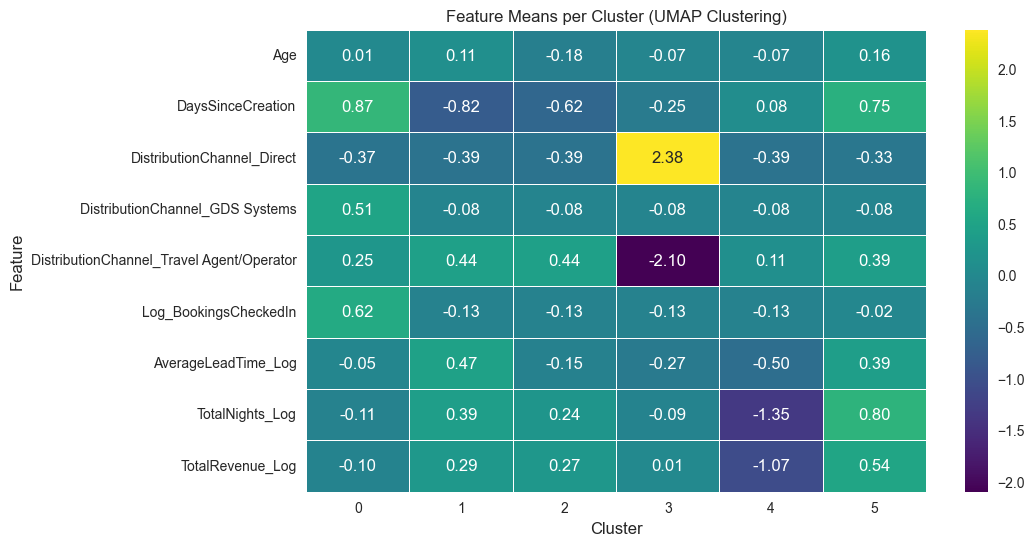

In [69]:

# Criar um gráfico de calor para melhor visualização
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5)
plt.title("Feature Means per Cluster (UMAP Clustering)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.show()


## Cluster Analysis
##### Cluster 0: Loyal, Low Spending Customers

- Long-term Customers: This group consists of customers who have been using the service for an extended period, indicating they have established relationships with the brand or platform.
- Traditional Booking Methods: They prefer more conventional, established booking channels, such as travel agents or global distribution systems, suggesting they value familiar, trusted channels for making their travel arrangements.
- Despite having a high amount of checked ins, have a low total revenue and total nights.

##### Cluster 1: New, Well-Prepared Customers

- Recently Onboarded: This group consists of new customers who have recently joined.
- Preference for Travel Agents: These customers prefer working with travel agents or operators, indicating they value personalized assistance when planning their trips.
- Thorough Planning: They have the longest lead time of any cluster, meaning they are meticulous planners who like to arrange their trips well in advance, showing a preference for preparing and organizing their travel plans early on.
- Good Spending: Although their total nights and revenue are not the highest, they show good spending habits, indicating that they are willing to invest in their travel experience.

##### Cluster 2: New and Spontaneous Customers 

- Recently Onboarded: This group comprises new customers who have recently joined.
- Preference for Travel Agents: Most of them prefer working with travel agents, indicating a reliance on personalized booking assistance.
- Moderate Spending: Their spending habits are moderate, reflecting a balanced approach to travel.
- Moderate Trip Duration: They tend to take moderate-length trips and spend an average amount on travel.
- Shorter Planning Time: They have a relative short lead time, showing a tendency for more spontaneous booking decisions compared to others.

##### Cluster 3: Independent Customers

- Balanced Engagement:  Neutral or Minimal level of engagement.
- Preference for Direct Booking: Despite the lower engagement, they prefer direct booking methods, indicating a preference for self-service and more - independent travel planning.
- Lower Spending: Their spending and trip duration are moderate to low, showing they are conservative spenders regarding travel.

##### Cluster 4: Worst Customers

- Minimal Engagement: This group shows very low total nights and very low total revenue, indicating low engagement and spending on travel.
- Short Planning Time: They have a short lead time, meaning they make last-minute bookings and may not engage deeply in planning.
- Low Value: These customers contribute less financially, making them less valuable for the platform or service.

##### Cluster 5: Best Customers

- Slightly Older Age: This group tends to be slightly older, suggesting they may be more established or experienced travelers.
- Long-Term Engagement: They have been using the service for a long time, indicating strong loyalty and long-term relationship.
- Preference for Travel Agents: They prefer working with travel agents, indicating they value personalized service and assistance.
- High Planning Time: They have a long lead time, showing they plan their trips well in advance.
- High Spending: This group has very high total nights and very high total revenue, indicating they are the biggest spenders and most engaged.